In [2]:
import os, sys, time
sys.path.append("../src")

from tqdm import tqdm
import numpy as np
import torch
import argparse
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

2024-05-01 16:28:19.495320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 16:28:20.510237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-01 16:28:20.510349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-01 16:28:20.510360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
ds_name = "c100"
start_idx = 9
tgt_label = 0

In [4]:
ig_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, "neuron_scores")
base_path = os.path.join(ig_dir, f"base_l{start_idx}tol12_{tgt_label}.npy")
ig_path = os.path.join(ig_dir, f"ig_list_l{start_idx}tol12_{tgt_label}.npy")
base = np.load(base_path)
ig = np.load(ig_path)

In [5]:
base.shape

(500, 3, 3072)

In [6]:
ig.shape

(500, 3, 3072)

si=10, li=0, ig[si][li].shape=(3072,)


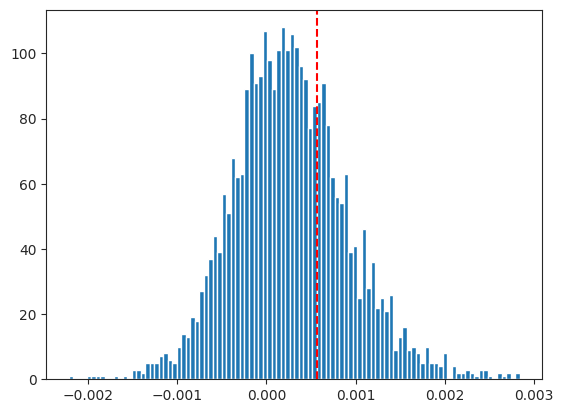

si=10, li=1, ig[si][li].shape=(3072,)


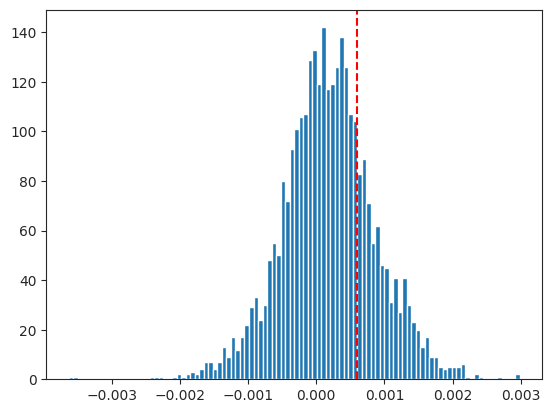

si=10, li=2, ig[si][li].shape=(3072,)


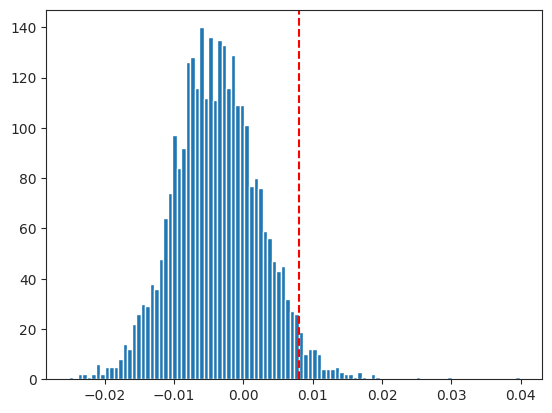

si=110, li=0, ig[si][li].shape=(3072,)


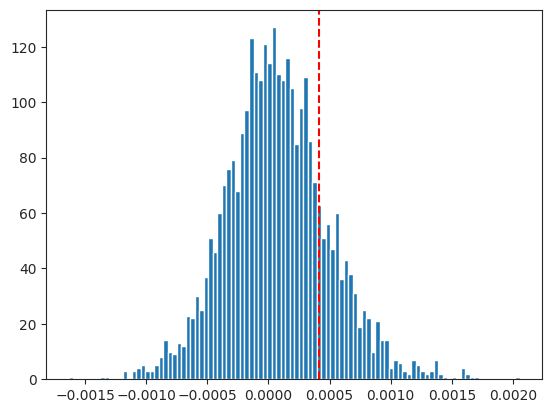

si=110, li=1, ig[si][li].shape=(3072,)


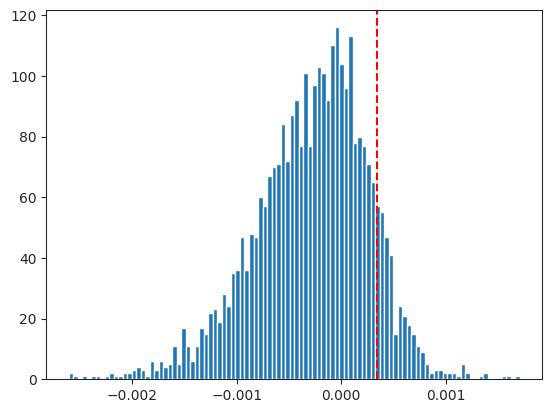

si=110, li=2, ig[si][li].shape=(3072,)


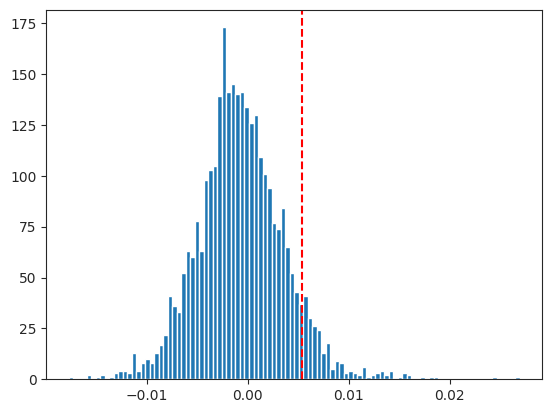

si=240, li=0, ig[si][li].shape=(3072,)


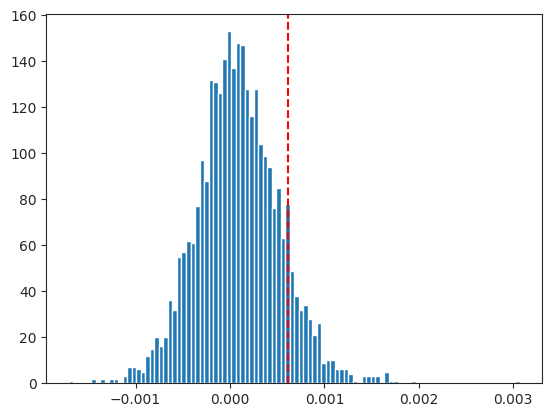

si=240, li=1, ig[si][li].shape=(3072,)


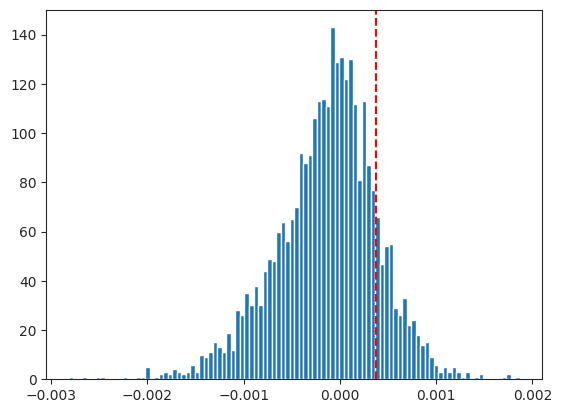

si=240, li=2, ig[si][li].shape=(3072,)


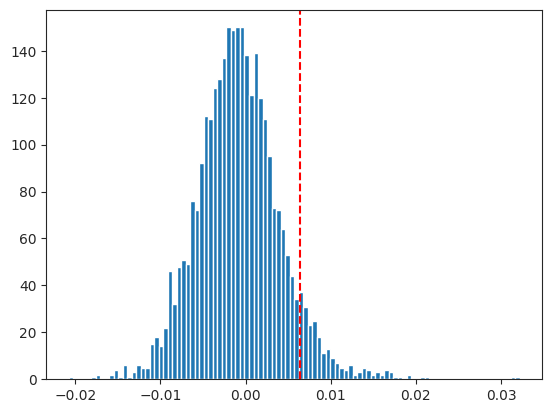

In [31]:
from itertools import product

si = [10, 110, 240]
li = [0, 1, 2]
for i, l in product(si, li):
    print(f"si={i}, li={l}, ig[si][li].shape={ig[i][l].shape}")
    # 例) ig[0]のヒストグラム
    plt.hist(ig[i][l].flatten(), bins=100)
    # 横軸がnp.max(ig[0]) * 0.2のところに縦線を引く
    plt.axvline(np.max(ig[i][l]) * 0.2, color='red', linestyle="--")
    plt.show()

In [8]:
from collections import Counter
kn_counter = Counter()

# 各サンプルのknowledge neuronを特定したい
for sample_idx, ig_sample in enumerate(ig):
    # t = 各サンプルのスコアの最大値の0.2倍 (サンプルごとのknに対する閾値)
    th_t = np.max(ig_sample) * 0.2
    # th_t以上のサンプルのインデックスのタプルを得る
    idxs = np.where(ig_sample >= th_t)
    # インデックスのタプルを1次元に変換
    t = [(l_id, n_id) for l_id, n_id in zip(idxs[0], idxs[1])]
    kn_counter.update(t)
    print(f"sample_idx: {sample_idx}, #kn candidates: {len(t)}")

sample_idx: 0, #kn candidates: 266
sample_idx: 1, #kn candidates: 155
sample_idx: 2, #kn candidates: 504
sample_idx: 3, #kn candidates: 122
sample_idx: 4, #kn candidates: 241
sample_idx: 5, #kn candidates: 158
sample_idx: 6, #kn candidates: 159
sample_idx: 7, #kn candidates: 190
sample_idx: 8, #kn candidates: 482
sample_idx: 9, #kn candidates: 121
sample_idx: 10, #kn candidates: 98
sample_idx: 11, #kn candidates: 129
sample_idx: 12, #kn candidates: 112
sample_idx: 13, #kn candidates: 87
sample_idx: 14, #kn candidates: 140
sample_idx: 15, #kn candidates: 104
sample_idx: 16, #kn candidates: 178
sample_idx: 17, #kn candidates: 175
sample_idx: 18, #kn candidates: 212
sample_idx: 19, #kn candidates: 258
sample_idx: 20, #kn candidates: 117
sample_idx: 21, #kn candidates: 223
sample_idx: 22, #kn candidates: 172
sample_idx: 23, #kn candidates: 129
sample_idx: 24, #kn candidates: 175
sample_idx: 25, #kn candidates: 129
sample_idx: 26, #kn candidates: 223
sample_idx: 27, #kn candidates: 228
samp

In [21]:
# サンプルごとの候補knを集計してレイヤごとにいくつあるか数える
ls = np.array([t[0] for t in kn_counter.keys()])
ls, cnt = np.unique(ls, return_counts=True)
ls, cnt

(array([0, 1, 2]), array([ 852, 1100, 1521]))

kn_cnt=350


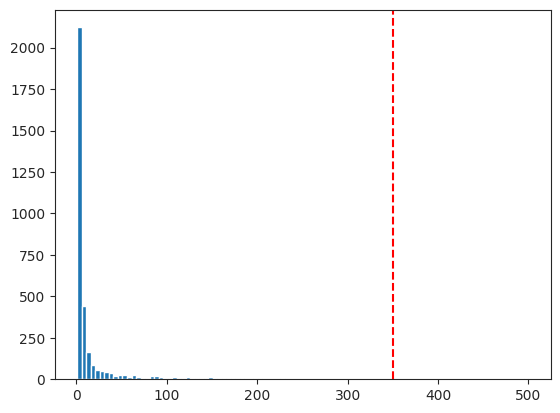

In [22]:
# 特定するknowledge neuronの個数
p = 0.7
kn_cnt = int(ig.shape[0] * p)
print(f"kn_cnt={kn_cnt}")
# kn_counterの値のヒストグラム（knの出現回数）
kn_values = list(kn_counter.values())
plt.axvline(kn_cnt, color='red', linestyle="--")
plt.hist(kn_values, bins=100)
plt.show()

In [23]:
# 同ラベルのサンプルのうちkn_cnt個以上で共有されている知識ニューロンを特定
kn = [(k, v) for k, v in kn_counter.items() if v >= kn_cnt]
len(kn)

58

In [12]:
kn

[((2, 17), 497),
 ((2, 30), 368),
 ((2, 91), 399),
 ((2, 125), 470),
 ((2, 262), 499),
 ((2, 304), 441),
 ((2, 333), 495),
 ((2, 350), 453),
 ((2, 396), 449),
 ((2, 609), 498),
 ((2, 638), 353),
 ((2, 725), 486),
 ((2, 734), 420),
 ((2, 804), 406),
 ((2, 842), 401),
 ((2, 920), 479),
 ((2, 959), 421),
 ((2, 1024), 483),
 ((2, 1081), 500),
 ((2, 1240), 366),
 ((2, 1263), 387),
 ((2, 1428), 353),
 ((2, 1483), 447),
 ((2, 1567), 483),
 ((2, 1692), 380),
 ((2, 1715), 500),
 ((2, 1778), 406),
 ((2, 1830), 458),
 ((2, 1924), 380),
 ((2, 1956), 385),
 ((2, 1971), 409),
 ((2, 1991), 424),
 ((2, 2004), 451),
 ((2, 2020), 364),
 ((2, 2049), 418),
 ((2, 2090), 473),
 ((2, 2114), 482),
 ((2, 2122), 470),
 ((2, 2148), 352),
 ((2, 2178), 439),
 ((2, 2209), 488),
 ((2, 2225), 497),
 ((2, 2249), 416),
 ((2, 2421), 500),
 ((2, 2467), 466),
 ((2, 2530), 497),
 ((2, 2660), 462),
 ((2, 2670), 438),
 ((2, 2694), 461),
 ((2, 2735), 369),
 ((2, 2778), 477),
 ((2, 2781), 500),
 ((2, 2787), 497),
 ((2, 2812), 

In [13]:
# サンプルごとの候補knを集計してレイヤごとにいくつあるか数える
ls = np.array([t[0][0] for t in kn])
ls, cnt = np.unique(ls, return_counts=True)
ls, cnt

(array([2]), array([58]))